In [1]:
import numpy as np
import random
from collections import defaultdict
import matplotlib.pyplot as plt

In [2]:
class TicTacToe:
    def __init__(self):
        self.board = np.zeros((3,3), dtype=int)  # 1: X, -1: O, 0: empty
        self.current_player = 1  # X always starts

    def reset(self):
        self.board[:] = 0
        self.current_player = 1
        return self.get_state()

    def get_state(self):
        """Return state as tuple (before normalization for symmetry)"""
        return tuple(self.board.flatten())

    def get_canonical_state(self):
        """Return canonical (symmetry-reduced) state representation"""
        # Generate all 8 symmetries and return the lexicographically smallest
        states = []
        board = self.board
        
        # 4 rotations
        for _ in range(4):
            states.append(tuple(board.flatten()))
            board = np.rot90(board)
        
        # 4 reflections
        board = np.fliplr(self.board)
        for _ in range(4):
            states.append(tuple(board.flatten()))
            board = np.rot90(board)
        
        return min(states)

    def legal_actions(self):
        return [(i,j) for i in range(3) for j in range(3)
                if self.board[i,j] == 0]

    def play(self, action):
        i, j = action
        self.board[i,j] = self.current_player
        self.current_player *= -1

    def winner(self):
        """Return winning player (1 or -1) or None"""
        lines = []
        lines.extend(self.board)
        lines.extend(self.board.T)
        lines.append(np.diag(self.board))
        lines.append(np.diag(np.fliplr(self.board)))

        for line in lines:
            if np.all(line == 1): return 1
            if np.all(line == -1): return -1
        return None

    def terminal(self):
        return self.winner() is not None or not self.legal_actions()


In [3]:
class TDAgent:
    """TD Learning agent with fixed player role"""
    def __init__(self, player, alpha=0.1, epsilon=0.0):
        self.player = player  # 1 for X, -1 for O
        self.V = defaultdict(lambda: 0.5)  # Value function for states
        self.alpha = alpha
        self.epsilon = epsilon

    def choose_action(self, env):
        """Choose action using epsilon-greedy strategy"""
        actions = env.legal_actions()
        
        if random.random() < self.epsilon:
            return random.choice(actions)

        # Evaluate each action by looking at resulting state
        best_val = -1e9
        best_action = None

        for a in actions:
            # Create copy of environment and simulate action
            temp = TicTacToe()
            temp.board = env.board.copy()
            temp.current_player = env.current_player
            temp.play(a)
            
            # Get canonical state (symmetry-reduced)
            v = self.V[temp.get_canonical_state()]

            if v > best_val:
                best_val = v
                best_action = a

        return best_action if best_action is not None else random.choice(actions)

    def update(self, s, s_next):
        """TD update: V(s) <- V(s) + alpha * (V(s_next) - V(s))"""
        self.V[s] += self.alpha * (self.V[s_next] - self.V[s])


In [4]:
def get_rewards(winner):
    """Get rewards for both players based on winner.
    Rewards are from each player's perspective:
    Win: 1.0, Loss: 0.0, Draw: 0.5"""
    if winner == 1:  # X wins
        return {1: 1.0, -1: 0.0}
    elif winner == -1:  # O wins
        return {1: 0.0, -1: 1.0}
    else:  # Draw
        return {1: 0.5, -1: 0.5}


In [5]:
def train_pair(agent_x, agent_o, episodes=10000):
    """Train two agents (X and O) with fixed roles against each other"""
    env = TicTacToe()
    
    x_wins, o_wins, draws = [], [], []
    xw = ow = d = 0

    for ep in range(episodes):
        s = env.reset()
        trajectory = []  # Store (state, canonical_state, player) for updates

        # Play game
        while not env.terminal():
            if env.current_player == 1:
                a = agent_x.choose_action(env)
            else:
                a = agent_o.choose_action(env)
            
            # Store state before move
            canonical_s = env.get_canonical_state()
            trajectory.append((canonical_s, env.current_player))
            
            env.play(a)

        # Get canonical state at terminal
        canonical_s_terminal = env.get_canonical_state()
        winner = env.winner()
        rewards = get_rewards(winner)
        
        # Set terminal value
        agent_x.V[canonical_s_terminal] = rewards[1]
        agent_o.V[canonical_s_terminal] = rewards[-1]

        # Update values using TD for both players
        for s, player in reversed(trajectory):
            if player == 1:
                agent_x.V[s] += agent_x.alpha * (agent_x.V[canonical_s_terminal] - agent_x.V[s])
            else:
                agent_o.V[s] += agent_o.alpha * (agent_o.V[canonical_s_terminal] - agent_o.V[s])

        # Track statistics
        if winner == 1:
            xw += 1
        elif winner == -1:
            ow += 1
        else:
            d += 1

        x_wins.append(xw / (ep + 1))
        o_wins.append(ow / (ep + 1))
        draws.append(d / (ep + 1))

    return agent_x, agent_o, x_wins, o_wins, draws


In [6]:
# Train all 4 strategy combinations
configs = [
    ("Greedy vs Greedy", 0.0, 0.0),
    ("Greedy vs ε-Greedy", 0.0, 0.1),
    ("ε-Greedy vs Greedy", 0.1, 0.0),
    ("ε-Greedy vs ε-Greedy", 0.1, 0.1),
]

results = {}

for config_name, eps_x, eps_o in configs:
    print(f"Training {config_name}...")
    agent_x = TDAgent(player=1, alpha=0.1, epsilon=eps_x)
    agent_o = TDAgent(player=-1, alpha=0.1, epsilon=eps_o)
    
    agent_x, agent_o, xw, ow, d = train_pair(agent_x, agent_o, episodes=10000)
    results[config_name] = {
        'agent_x': agent_x,
        'agent_o': agent_o,
        'x_wins': xw,
        'o_wins': ow,
        'draws': d
    }
    print(f"  X Wins: {xw[-1]:.3f}, O Wins: {ow[-1]:.3f}, Draws: {d[-1]:.3f}")


Training Greedy vs Greedy...
  X Wins: 1.000, O Wins: 0.000, Draws: 0.000
Training Greedy vs ε-Greedy...
  X Wins: 0.852, O Wins: 0.127, Draws: 0.022
Training ε-Greedy vs Greedy...
  X Wins: 0.944, O Wins: 0.055, Draws: 0.001
Training ε-Greedy vs ε-Greedy...
  X Wins: 0.841, O Wins: 0.144, Draws: 0.015


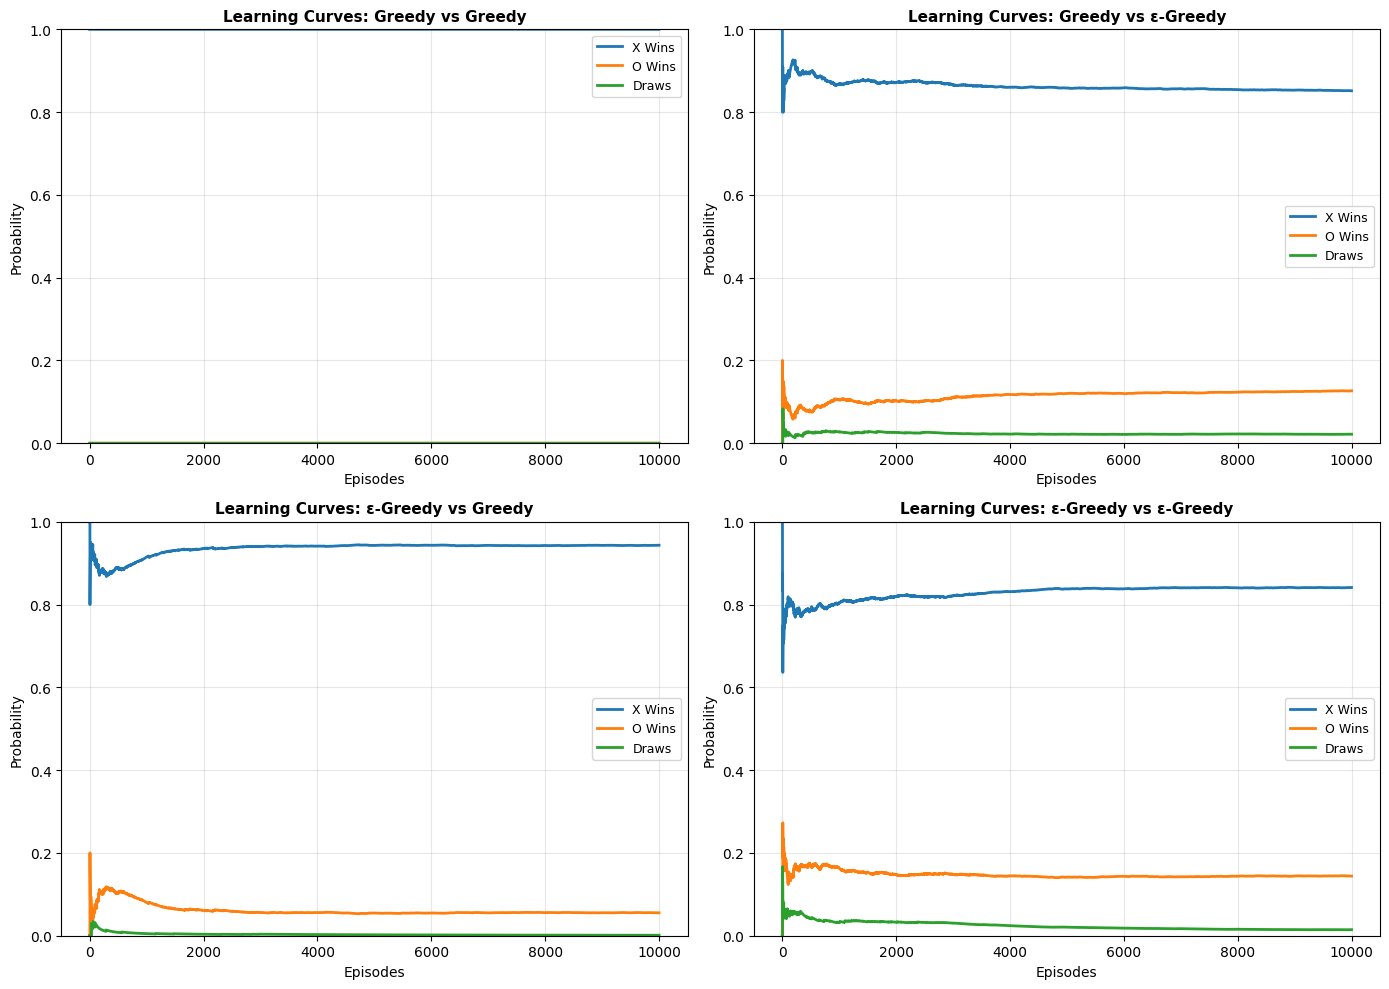

In [7]:
# Plot learning curves for all configurations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, (config_name, result) in enumerate(results.items()):
    ax = axes[idx]
    
    x_wins = result['x_wins']
    o_wins = result['o_wins']
    draws = result['draws']
    
    ax.plot(x_wins, label="X Wins", linewidth=2)
    ax.plot(o_wins, label="O Wins", linewidth=2)
    ax.plot(draws, label="Draws", linewidth=2)
    
    ax.set_xlabel("Episodes", fontsize=10)
    ax.set_ylabel("Probability", fontsize=10)
    ax.set_title(f"Learning Curves: {config_name}", fontsize=11, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_ylim([0, 1])

plt.tight_layout()
plt.show()


In [8]:
def play_game(agent_x, agent_o, greedy=True):
    """Play a game with trained agents"""
    env = TicTacToe()
    env.reset()
    
    if greedy:
        agent_x.epsilon = 0
        agent_o.epsilon = 0

    trajectory = []

    while not env.terminal():
        if env.current_player == 1:
            action = agent_x.choose_action(env)
        else:
            action = agent_o.choose_action(env)
        
        trajectory.append((env.get_state(), action, env.current_player))
        env.play(action)

    return trajectory, env.winner()

def print_game(trajectory, winner):
    """Print game trajectory"""
    sym = {1: "X", -1: "O", 0: "."}
    
    print("Game Trajectory:")
    for t, (s, a, player) in enumerate(trajectory):
        print(f"\nStep {t+1}: Player {sym[player]} plays at {a}")
        board = np.array(s).reshape(3, 3)
        for r in board:
            print(" ".join(sym[int(x)] for x in r))
    
    if winner == 1:
        print("\nResult: X Wins!")
    elif winner == -1:
        print("\nResult: O Wins!")
    else:
        print("\nResult: Draw!")


In [9]:
# Demonstrate final trained agents
config_name = "ε-Greedy vs ε-Greedy"
agent_x = results[config_name]['agent_x']
agent_o = results[config_name]['agent_o']

print(f"Playing game with {config_name} agents:\n")
trajectory, winner = play_game(agent_x, agent_o, greedy=True)
print_game(trajectory, winner)


Playing game with ε-Greedy vs ε-Greedy agents:

Game Trajectory:

Step 1: Player X plays at (0, 0)
. . .
. . .
. . .

Step 2: Player O plays at (0, 1)
X . .
. . .
. . .

Step 3: Player X plays at (0, 2)
X O .
. . .
. . .

Step 4: Player O plays at (1, 0)
X O X
. . .
. . .

Step 5: Player X plays at (1, 1)
X O X
O . .
. . .

Step 6: Player O plays at (1, 2)
X O X
O X .
. . .

Step 7: Player X plays at (2, 0)
X O X
O X O
. . .

Result: X Wins!


In [10]:
# Summary statistics
print("\n" + "="*60)
print("FINAL TRAINING STATISTICS")
print("="*60)

for config_name, result in results.items():
    xw = result['x_wins'][-1]
    ow = result['o_wins'][-1]
    d = result['draws'][-1]
    print(f"\n{config_name}:")
    print(f"  X Win Rate: {xw:.4f} | O Win Rate: {ow:.4f} | Draw Rate: {d:.4f}")



FINAL TRAINING STATISTICS

Greedy vs Greedy:
  X Win Rate: 1.0000 | O Win Rate: 0.0000 | Draw Rate: 0.0000

Greedy vs ε-Greedy:
  X Win Rate: 0.8515 | O Win Rate: 0.1267 | Draw Rate: 0.0218

ε-Greedy vs Greedy:
  X Win Rate: 0.9435 | O Win Rate: 0.0553 | Draw Rate: 0.0012

ε-Greedy vs ε-Greedy:
  X Win Rate: 0.8414 | O Win Rate: 0.1440 | Draw Rate: 0.0146
